# <font color='#1a5276'> <b> <center> Linear Regression - Multiple predictors </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Data](#3) <br>
4. [Model, cost function and DataLoader](#4) <br>
5. [Training and predictions](#5)
6. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

In this notebook, we will explore a Linear Regression problem with multiple predictors. Unlike our previous work with a single predictor, we now consider multiple input variables, each contributing to the prediction of the target variable. This shift introduces new opportunities and challenges, as we move from fitting a simple line to fitting a higher-dimensional hyperplane.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from torch import nn,optim
import torch
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader

In [3]:
# Set the random seed to 1. 
torch.manual_seed(1)

<a name="3"></a>
## <font color='blue'> <b> 3. Helper Functions </b> </font>

In [4]:
# The function for plotting 2D
def Plot_2D_Plane(model, dataset, n=0):
    # Extract weights and bias from the model's state dictionary
    w1 = model.state_dict()['linear.weight'].numpy()[0][0]  # Weight for the first predictor
    w2 = model.state_dict()['linear.weight'].numpy()[0][1]  # Weight for the second predictor
    b = model.state_dict()['linear.bias'].numpy()          # Bias term

    # Extract data points from the dataset
    x1 = dataset.x[:, 0].view(-1, 1).numpy()  # Values for the first predictor
    x2 = dataset.x[:, 1].view(-1, 1).numpy()  # Values for the second predictor
    y = dataset.y.numpy()                     # Target values

    # Create a mesh grid to generate the plane
    X, Y = np.meshgrid(np.arange(x1.min(), x1.max(), 0.05), np.arange(x2.min(), x2.max(), 0.05))
    yhat = w1 * X + w2 * Y + b  # Compute predictions for the plane

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')  # Set the projection to 3D

    # Plot the data points as red circles
    ax.plot(x1[:, 0], x2[:, 0], y[:, 0], 'ro', label='y')  # Scatter plot for data points
    
    # Plot the estimated plane
    ax.plot_surface(X, Y, yhat)  # Surface plot for the regression plane
    
    # Label the axes
    ax.set_xlabel('x1 ')  # Label for the first predictor
    ax.set_ylabel('x2 ')  # Label for the second predictor
    ax.set_zlabel('y')    # Label for the target variable
    
    # Add a title with the iteration number
    plt.title('Estimated plane iteration:' + str(n))
    
    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


<a name="4"></a>
## <font color='blue'> <b> 4. Data </b> </font>

We will create synthetic data.

In [5]:
class Data2D(Dataset):
    
    # Constructor
    def __init__(self):
        # Initialize input features as a 20x2 tensor
        self.x = torch.zeros(20, 2)
        self.x[:, 0] = torch.arange(-1, 1, 0.1)  # Fill the first column with values from -1 to 1
        self.x[:, 1] = torch.arange(-1, 1, 0.1)  # Fill the second column with the same range

        # Define the true weights and bias for the linear function
        self.w = torch.tensor([[1.0], [1.0]])  # True weights for both predictors
        self.b = 1                            # True bias term

        # Compute the ideal output (without noise) based on the linear equation
        self.f = torch.mm(self.x, self.w) + self.b

        # Add random noise to the ideal output to create target values
        self.y = self.f + 0.1 * torch.randn((self.x.shape[0], 1))  # Adding Gaussian noise

        # Store the number of data points
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):
        # Return the feature vector and corresponding target value for the given index
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        # Return the number of data points in the dataset
        return self.len


In [6]:
# Create the dataset object
dataset = Data2D()

<a name="5"></a>
## <font color='blue'> <b> 5. Model, optimizer and cost function </b> </font>

In [7]:
class linear_regression(nn.Module):
    
    # constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # prediction
    def forward(self, x):
        return self.linear(x)



In [8]:
# Create the linear regression model and print the parameters
model = linear_regression(2, 1)
print("The parameters: ", list(model.parameters()))

The parameters:  [Parameter containing:
tensor([[ 0.6209, -0.1178]], requires_grad=True), Parameter containing:
tensor([0.3026], requires_grad=True)]


In [9]:
# Create the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [10]:
# Create the cost function
criterion = nn.MSELoss()

In [11]:
# Create the data loader
train_loader = DataLoader(dataset=dataset, batch_size=2)

<a name="6"></a>
## <font color='blue'> <b> 6. Training </b> </font>

We will train using the gradient descent algorithm and store the cost for each iteration. Remember that this is actually an approximation of the true cost.

In [12]:
def train(train_loader, epochs):
    """
    Train the model using data from the provided data loader.

    Args:
        train_loader (DataLoader): DataLoader for the training dataset.
        epochs (int): Number of epochs to train the model.

    Returns:
        list: A list containing the loss value for each iteration.
    """
    
    # Initialize a list to store loss values for each iteration
    loss_results = []
    
    # Iterate through the specified number of epochs
    for epoch in range(epochs):
        # Loop through the batches of data in the train_loader
        for x, y in train_loader:
            # Compute the model's prediction
            yhat = model(x)
            # Calculate the loss between prediction and true values
            loss = criterion(yhat, y)
            # Append the current loss value to the results list
            loss_results.append(loss.item())
            # Reset the gradients of the optimizer
            optimizer.zero_grad()
            # Compute gradients for all model parameters
            loss.backward()
            # Update model parameters using the optimizer
            optimizer.step()
            
    # Return the list of loss values
    return loss_results

            


Before Training: 


/tmp/ipykernel_733539/3917124747.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # Set the projection to 3D


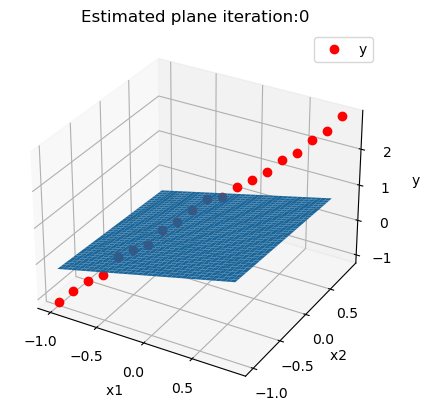

In [13]:
print("Before Training: ")
Plot_2D_Plane(model, dataset) 

In [14]:
# train
loss_results = train(train_loader, 100)

After Training: 


/tmp/ipykernel_733539/3917124747.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # Set the projection to 3D


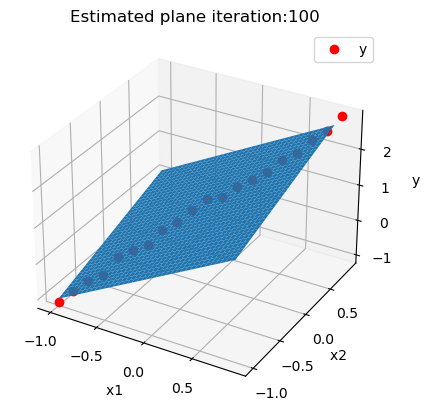

In [15]:
print("After Training: ")
Plot_2D_Plane(model, dataset, 100) 

We can see that after training, the plane fits the data much better.

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)